<a href="https://colab.research.google.com/github/detergentyoon/machine-learning/blob/main/cnn-image-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive

# Google Drive를 마운트
#   - Google Drive에 업로드한 로컬 파일을 Colab에서 액세스할 수 있도록 만듦
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import os

# 데이터셋 경로
data_dir = '/content/drive/My Drive/data_set'
os.listdir(data_dir)  # data_set 디렉토리 내의 파일 확인

['test', 'train']

In [ ]:
# # ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
# # 이미지 파일을 실제 디렉토리 상에서 옮겨서 분리시키는 경우

# # 검증 데이터 디렉토리 경로 설정 및 생성
# val_data_dir = '/content/drive/My Drive/data_set/validation'
# os.makedirs(val_data_dir, exist_ok = True)
# #   - val_data_dir : 디렉토리를 생성할 경로
# #   - exist_ok = True : 디렉토리가 이미 존재하는 경우에도 에러를 발생시키지 않고 정상적으로 실행되도록 함

# # 검증 데이터 클래스 별 디렉토리 경로 설정 및 생성
# val_data_circle_dir = '/content/drive/My Drive/data_set/validation/circle'
# val_data_triangle_dir = '/content/drive/My Drive/data_set/validation/triangle'
# val_data_rectangle_dir = '/content/drive/My Drive/data_set/validation/rectangle'
# val_data_star_dir = '/content/drive/My Drive/data_set/validation/star'
# os.makedirs(val_data_circle_dir, exist_ok = True)
# os.makedirs(val_data_triangle_dir, exist_ok = True)
# os.makedirs(val_data_rectangle_dir, exist_ok = True)
# os.makedirs(val_data_star_dir, exist_ok = True)

# # 훈련 데이터 경로
# train_data_dir = '/content/drive/My Drive/data_set/train'

# # 훈련 세트의 20%를 검증 세트로 분리
# for class_folder in os.listdir(train_data_dir):
#     # 각 클래스 폴더 별로 이미지 복사 및 이동 동작을 반복
#     class_path = os.path.join(train_data_dir, class_folder)  # 현재 클래스 폴더의 경로 생성
#     num_images = len(os.listdir(class_path))  # 현재 클래스 폴더 내 이미지 파일 수 계산
#     num_validation = int(num_images * 0.2)  # 검증 데이터의 비율 (20%)

#     image_files = os.listdir(class_path)  # 현재 클래스 폴더 내의 모든 이미지 파일 이름 가져오기

#     # 클래스 폴더 내의 이미지 파일을 순회
#     for image_file in image_files[:num_validation]:
#     #   - image_files : 현재 클래스 폴더 내의 모든 이미지 파일명 목록

#         src = os.path.join(class_path, image_file)  # 현재 이미지 파일의 소스 경로 생성
#         #   - class_path : 현재 클래스 폴더의 경로
#         #   - image_file : 현재 순회 중인 이미지 파일명

#         dst = os.path.join(val_data_dir, class_folder, image_file)  # 목적지 경로 생성 (검증 데이터 디렉토리 내)
#         #   - val_data_dir : 검증 데이터가 저장될 디렉토리의 경로
#         #   - class_folder : 현재 클래스명(폴더명을 의미)
#         #   - image_file : 이미지 파일명

#         shutil.move(src, dst)  # 현재 이미지 파일을 검증 데이터 디렉토리 내의 목적지 경로로 이동

# # ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

In [51]:
import tensorflow as tf
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

# 이미지 리사이징 크기 설정 (24 x 24)
image_size = (24, 24)

# 데이터 전처리 함수
def preprocess_images(train_data_dir, image_size):
    x = []  # 이미지 데이터를 저장할 리스트
    y = []  # 이미지 레이블을 저장할 리스트

    # 클래스 폴더 목록을 가져와 각 클래스에 대한 index를 매핑하는 딕셔너리 생성
    class_folders = os.listdir(train_data_dir)  # 훈련 데이터 디렉토리 내에 있는 클래스 폴더 목록을 가져옴
    class_mapping = {class_folder: i for i, class_folder in enumerate(class_folders)}
    #   - enumerate(class_folders) : class_folders 리스트의 각 요소에 대해 인덱스와 요소를 함께 반환
    #   - {} 표현식 : class_folder를 key로 하고 해당 클래스의 index인 i를 값으로 하는 딕셔너리 생성
    #       ㄴ (딕셔너리 내포, dictionary comprehension)

    for class_folder in class_folders:
        class_path = os.path.join(train_data_dir, class_folder)  # 클래스 폴더 경로 생성
        class_idx = class_mapping[class_folder]  # 클래스명을 클래스 index로 사용

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)  # 이미지 파일 경로 생성
            img = Image.open(image_path)  # 이미지 파일 열기

            img = img.resize(image_size)  # 이미지 크기 조정

            img = img.convert('L')  # 이미지를 흑백(Grayscale)으로 변환

            img_array = np.array(img) / 255.0  # 이미지를 배열로 변환하고 픽셀 값을 0에서 1 범위로 정규화

            # 데이터 및 레이블 추가
            x.append(img_array)  # 이미지 데이터를 x 리스트에 추가
            y.append(class_idx)  # 이미지 레이블을 y 리스트에 추가

    return np.array(x), np.array(y), class_mapping  # 이미지 데이터와 레이블을 NumPy 배열로 반환

# 이미지 데이터(x)와 레이블(y) 획득
x, y, class_mapping = preprocess_images(train_data_dir, image_size)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 22, 22, 32)        320       
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 11, 11, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 4, 4, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 2, 2, 128)         73856     
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 1, 1, 128)       

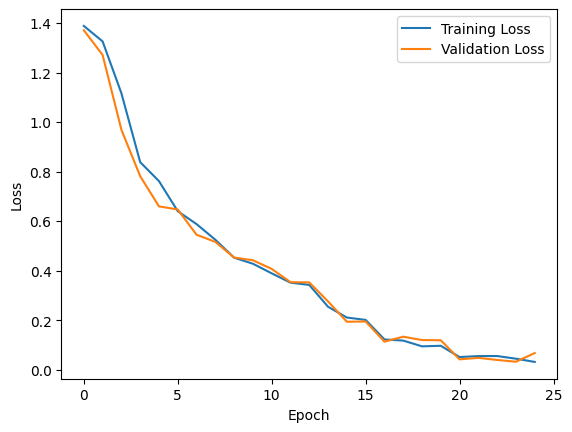

2/2 [==============================] - 0s 9ms/step
001 : Triangle
002 : Star
003 : Triangle
004 : Rectangle
005 : Star
006 : Star
007 : Circle
008 : Triangle
009 : Circle
010 : Circle
011 : Rectangle
012 : Circle
013 : Star
014 : Rectangle
015 : Triangle
016 : Triangle
017 : Circle
018 : Star
019 : Triangle
020 : Triangle
021 : Rectangle
022 : Circle
023 : Circle
024 : Rectangle
025 : Star
026 : Star
027 : Circle
028 : Triangle
029 : Star
030 : Rectangle
031 : Star
032 : Star
033 : Circle
034 : Circle
035 : Circle
036 : Triangle
037 : Triangle
038 : Triangle
039 : Circle
040 : Circle


In [53]:
from sklearn.model_selection import train_test_split

# 데이터를 훈련, 검증, 테스트 세트로 분할
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, random_state = 42)
#   - x_train : 전체 데이터의 80%를 포함하는 훈련 세트의 입력 데이터
#   - x_temp : 훈련 세트에서 나머지 20%의 데이터(검증 세트와 테스트 세트의 합)의 입력 데이터
#   - y_train : 전체 데이터의 80%를 포함하는 훈련 세트의 레이블 데이터
#   - y_temp : 훈련 세트에서 나머지 20%의 데이터(검증 세트와 테스트 세트의 합)의 레이블 데이터
#       - temp 변수 : 검증 세트와 테스트 세트를 나누기 전에 임시로 저장되는 역할

# 이미지 분류 모델에서의 입력 데이터 : 데이터 샘플 (이미지)
# 이미지 분류 모델에서의 레이블 데이터 : 입력 데이터에 대한 정답 (어떤 클래스, 범주에 속하는지를 나타내는 정보)



# 레이블을 one-hot 인코딩으로 변환
#   - one-hot Encoding : 다중 클래스 분류 문제에서 주로 사용되는 방법으로, 각 클래스 레이블을 이진 벡터로 표현
#       0  ->  [1, 0, 0, 0]
#       1  ->  [0, 1, 0, 0]
#       2  ->  [0, 0, 1, 0]
#       3  ->  [0, 0, 0, 1]
y_train = tf.keras.utils.to_categorical(y_train, 4)
y_val = tf.keras.utils.to_categorical(y_val, 4)
y_test = tf.keras.utils.to_categorical(y_test, 4)



# Keras를 통해 모델 정의
model = Sequential([
    # 첫 번째 합성곱 레이어
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (*image_size, 1)),
    #   - 32: 32개의 필터 사용
    #   - (3, 3): 각 필터의 크기 3 x 3
    #   - activation = 'relu': 활성화 함수로 ReLU 사용
    #   - input_shape = (*image_size, 1): 입력 이미지 크기와 채널 수 정의, grayscale 이미지이므로 1채널

    # 첫 번째 최대 풀링 레이어
    MaxPooling2D((2, 2)),
    #   - (2, 2): 2x2 크기의 최대 풀링을 수행

    # 두 번째 합성곱, 최대 풀링 레이어
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),

    # 세 번째 합성곱, 최대 풀링 레이어
    Conv2D(128, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),

    # 데이터를 1차원 배열화시키는 레이어
    Flatten(),

    # 완전 연결 레이어
    Dense(512, activation = 'relu'),
    #   - 512: 512개의 뉴런을 가진 완전 연결 레이어

    # 드롭아웃 레이어
    Dropout(0.5),
    #   - 0.5: 드롭아웃 비율, 50%의 뉴런을 랜덤하게 비활성화

    # 출력 레이어
    Dense(4, activation = 'softmax')
    #   - 4: 출력 클래스 수, 이 모델은 4개의 클래스를 분류
    #   - activation = 'softmax': 활성화 함수로 softmax 사용
])



# 모델 컴파일
model.compile(optimizer = 'adam',
              # adam 옵티마이저 사용

              loss = 'categorical_crossentropy',
              # 손실 함수 설정, 다중 클래스 분류에 사용되는 categorical cross-entropy 사용

              metrics = ['accuracy'])
              #   - accuracy: 모델의 평가 지표로 `정확도` 사용

# 모델 요약 출력
#   - 각 레이어의 구성과 파라미터 수 표시
model.summary()



# 모델 훈련
history = model.fit(
    x_train.reshape(-1, *image_size, 1), y_train,
    #   - x_train.reshape(-1, *image_size, 1): 입력 데이터를 모델이 기대하는 형태로 변환
    #   - y_train: 훈련 데이터의 레이블

    epochs = 25,  # epoch 반복 횟수 설정

    validation_data = (x_val.reshape(-1, *image_size, 1), y_val)
    #   - validation_data: 검증 데이터 설정, x_val과 y_val을 사용하여 모델의 성능 검증
)



# 평가 함수 호출
test_loss, test_accuracy = model.evaluate(x_test.reshape(-1, *image_size, 1), y_test)
#   - model.evaluate(): 모델을 사용하여 테스트 데이터를 평가하고 손실과 정확도를 반환
#   - x_test.reshape(-1, *image_size, 1): 입력 데이터를 모델이 기대하는 형태로 변환
#   - y_test: 테스트 데이터의 실제 레이블

print(f'\n=== Test Loss: {test_loss:.4f}')
print(f'=== Test Accuracy: {test_accuracy * 100:.2f}%\n')
#   - Test Loss: 테스트 데이터의 평가 손실 출력
#   - Test Accuracy: 테스트 데이터의 평가 정확도 출력



# 손실 그래프 출력
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




# 클래스명과 클래스 인덱스의 매핑 딕셔너리
class_index_to_name = {i: class_name for class_name, i in class_mapping.items()}
#   - class_mapping: 클래스명과 인덱스의 매핑 딕셔너리
#   - class_index_to_name: 인덱스를 사용하여 클래스명을 찾을 수 있는 딕셔너리 생성

# 테스트 데이터 예측
test_predictions = model.predict(x_test.reshape(-1, *image_size, 1))
#   - model.predict(): 모델을 사용하여 테스트 데이터에 대한 예측 수행
predicted_classes = [class_index_to_name[np.argmax(prediction)] for prediction in test_predictions]
#   - 예측 결과를 클래스명으로 변환하여 리스트에 저장

# 예측 결과 출력
for i in range(len(predicted_classes)):
    print(f"{i + 1:03} : {predicted_classes[i].title()}")